### Synthetic Dataset

* Recreating Maggie's AAAI synthetic dataset
* Stochastic Block Model (SBM) -> use Networkx generator
* Maggie set her networks to size 500, with 0.5 and 0.01 within and across sub-community edge probabilities. 

Maggie's Generative Model
For every individual $i$:
1. For each neighbor $j \in n(i)$, draw the spreader state: $z_j \sim Bernoulli(\sigma(\boldsymbol{u}^T \boldsymbol{x_j} ))$
    * We are going to replace $z_j$ with the colonization pressure as calculated in the rolling risk model. CP $\in[0,1]$.
2. Draw the probability of exposure: $\theta_i|\boldsymbol{z_i} \sim Beta(1+\sum_{n(i)}z_j, 1+\sum_{n(i)}1-z_j)$
    * I visualized these resulting beta distributions and I wans't seeing the pattern we would expect: the more positive neighbors, the more right skewed the distribution. 
    * Simply combine using average
3. Draw exposure state: $\eta_i | \theta_i \sim Bernoulli(\theta_i)$


In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import os
from sklearn.metrics import roc_auc_score
from sklearn import linear_model
import torch
import pandas as pd
from sklearn.utils import resample
import difflib

from inprog166v22_jx import return_file_name, \
    format_data, new_location_codes, calc_CP, map_feature_names, \
    process_top_features, \
    auroc, preload_data, \
    graph_split, data_bundler, train_models, GCNa11

def emp_bootstrap_auc(y_true, y_pred, sample_auroc, n=1000, percentile=0.95):
    
    scores = []
    while True:
        try:
            _y_true, _y_pred = resample(y_true, y_pred)
            scores.append(roc_auc_score(_y_true, _y_pred))
        except:
            pass
        if len(scores)>=n:
            break
        
    deltas = scores - sample_auroc
    deltas.sort()
    ub_idx = int(n*((1-percentile)/2)) # "p.5"
    lb_idx = int(n*(percentile+(1-percentile)/2)) # "p.95" 
    return(sample_auroc - deltas[lb_idx], sample_auroc - deltas[ub_idx])

In [2]:
def gen_network(args):
    
    # Network 
    edge_p = np.diag([args['in_p']-args['out_p']]*args['num_blocks']) 
    edge_p = edge_p + np.ones((args['num_blocks'],args['num_blocks']))*args['out_p']
    g = nx.stochastic_block_model(args['block_sizes'], edge_p)
    
    # Spreader State (aka CP)
    pos_nodes = np.random.choice(g.nodes, size=int(len(g.nodes)*args['pos_p']), replace=False)
    timesteps = np.random.choice(np.arange(args['max_pos_timestep']), size=len(pos_nodes))
    timesteps_norm = (-timesteps + args['max_pos_timestep'])/args['max_pos_timestep']
    symptomatic = np.random.binomial(1,args['symp_p'],size=len(pos_nodes))
    cp = 1-(np.minimum(timesteps,args['cp_decay']))*(1/args['cp_decay'])
    
    
    cp_decay_half = int(args['cp_decay']/2)
    cp_half = 1-(np.minimum(timesteps,cp_decay_half))*(1/cp_decay_half)

    attrs = {(i):{'positive':1 if i in pos_nodes else 0,
                  'days_since_pos': timesteps[np.where(pos_nodes==i)][0] if i in pos_nodes else np.nan,
                  'cp': cp[np.where(pos_nodes==i)][0] if i in pos_nodes else 0,
                  'cp_half': cp_half[np.where(pos_nodes==i)][0] if i in pos_nodes else 0,
                  'days_since_pos_norm': timesteps_norm[np.where(pos_nodes==i)][0] if i in pos_nodes else 0,
                  'symptomatic': symptomatic[np.where(pos_nodes==i)][0] if i in pos_nodes else 0}
             for i in range(len(g.nodes))}
    nx.set_node_attributes(g, attrs)
    
    # Exposure
    attrs = {}
    for i in g.nodes:
        
        neigh_cp_true = [nx.get_node_attributes(g,'cp')[j] for j in nx.all_neighbors(g,i) 
                    if nx.get_node_attributes(g,'symptomatic')[j]==1]
        neigh_cp = [nx.get_node_attributes(g,'cp')[j] for j in nx.all_neighbors(g,i)]
        neigh_cp_half = [nx.get_node_attributes(g,'cp_half')[j] for j in nx.all_neighbors(g,i)]
        
        if len(neigh_cp)>0:
            avg_cp = np.mean(neigh_cp)
            avg_cp_half = np.mean(neigh_cp_half)
        else: 
            avg_cp, avg_cp_half = 0, 0
            
        if len(neigh_cp_true)>0:
            true_cp = np.mean(neigh_cp_true)
        else:
            true_cp = 0

        exposure = np.random.binomial(1,true_cp)
        attrs[i] = {'avg_cp': avg_cp,
                    'avg_cp_half': avg_cp_half,
                    'true_cp': true_cp,
                    'exposure': exposure}
    nx.set_node_attributes(g, attrs)
    print('Class Balance: {:.2f}'.format(np.mean([nx.get_node_attributes(g,'exposure')[i] for i in g.nodes])))
    return g

In [3]:
gen_model_args = {
    'num_blocks': 10,
    'in_p': 0.5,
    'out_p': 0.01,
    'pos_p': 0.2, # higher the more balanced
    'symp_p': 0.25,
    'max_pos_timestep': 30, # lower the more balanced
    'cp_decay': 14,
    'savepath': 'data150jx', # 'data150v3-7'
    'num_datasets_train': 1000, # make it lower to run faster
    'num_datasets_val': 20,
    'num_datasets_test': 20,
}
gen_model_args['num_datasets'] = gen_model_args['num_datasets_train'] + gen_model_args['num_datasets_val'] + gen_model_args['num_datasets_test']
gen_model_args['block_sizes'] = np.random.choice(np.arange(5,20), size=gen_model_args['num_blocks'])

In [4]:
for d in range(gen_model_args['num_datasets']):
    zg = gen_network(gen_model_args)
    nx.write_gpickle(zg, os.path.join(gen_model_args['savepath'],'g'+str(d)+'.pkl'))

Class Balance: 0.14
Class Balance: 0.05
Class Balance: 0.20
Class Balance: 0.09
Class Balance: 0.17
Class Balance: 0.05
Class Balance: 0.17
Class Balance: 0.15
Class Balance: 0.08
Class Balance: 0.00
Class Balance: 0.08
Class Balance: 0.09
Class Balance: 0.03
Class Balance: 0.13
Class Balance: 0.15
Class Balance: 0.10
Class Balance: 0.03
Class Balance: 0.07
Class Balance: 0.01
Class Balance: 0.05
Class Balance: 0.14
Class Balance: 0.15
Class Balance: 0.07
Class Balance: 0.12
Class Balance: 0.06
Class Balance: 0.09
Class Balance: 0.07
Class Balance: 0.11
Class Balance: 0.19
Class Balance: 0.13
Class Balance: 0.09
Class Balance: 0.12
Class Balance: 0.11
Class Balance: 0.11
Class Balance: 0.25
Class Balance: 0.14
Class Balance: 0.13
Class Balance: 0.02
Class Balance: 0.15
Class Balance: 0.09
Class Balance: 0.02
Class Balance: 0.06
Class Balance: 0.11
Class Balance: 0.15
Class Balance: 0.17
Class Balance: 0.14
Class Balance: 0.15
Class Balance: 0.09
Class Balance: 0.06
Class Balance: 0.15


In [5]:
np.save(os.path.join(gen_model_args['savepath'],"args.npy"),gen_model_args)

In [6]:
# Report Class Imbalance
dataname = gen_model_args['savepath'] 
gen_model_args = np.load(os.path.join(dataname,'args.npy'), allow_pickle=True).item()
class_imb = []
for i in range(gen_model_args['num_datasets']):
    zg = nx.read_gpickle(os.path.join(gen_model_args['savepath'],'g'+str(i)+'.pkl'))
    class_imb.append(np.mean([nx.get_node_attributes(zg,'exposure')[j] for j in zg.nodes]))
    
print('Avg Train Class Imb: {:.2f}'.format(np.mean(class_imb[:gen_model_args['num_datasets_train']])))
print('Avg Test Class Imb: {:.2f}'.format(np.mean(class_imb[-gen_model_args['num_datasets_test']:])))

Avg Train Class Imb: 0.09
Avg Test Class Imb: 0.07


In [7]:
# Add Train/Val Class Imbalance Into ARgs
gen_model_args['trainval_class_imb'] = np.mean(class_imb[:-gen_model_args['num_datasets_test']])
np.save(os.path.join(gen_model_args['savepath'],"args.npy"),gen_model_args)

Missclassification  data150jx
true_cp MSE: 0.000
avg_cp MSE: 0.042
avg_cp_half MSE: 0.047


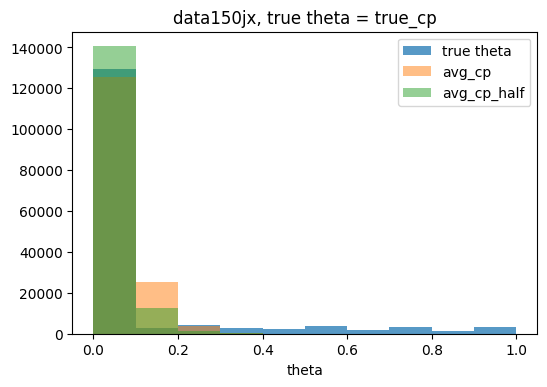

true_cp AUC = 0.9816
avg_cp AUC = 0.8381
avg_cp_half AUC = 0.7871


<Figure size 432x288 with 0 Axes>

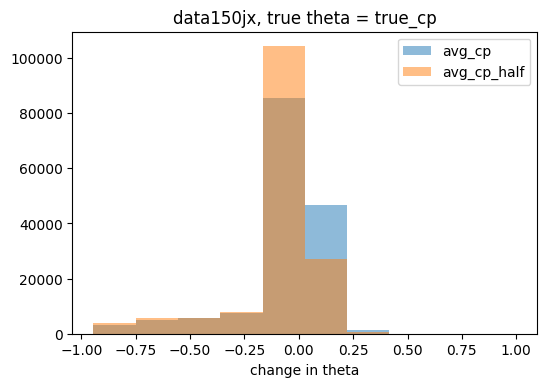

avg_cp Avg: 0.004
avg_cp_half Avg: 0.009


<Figure size 432x288 with 0 Axes>

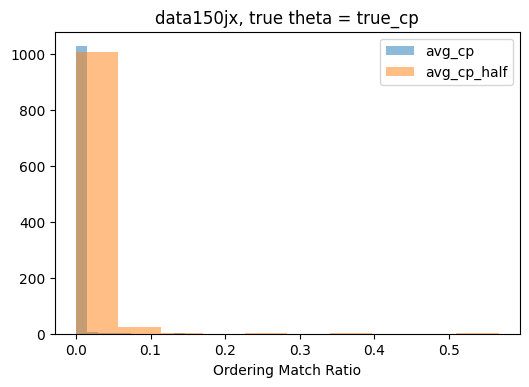

<Figure size 432x288 with 0 Axes>

In [8]:
# Report Misclassification
def calc_missclass(dataname, true_cp_name, alt_cp_name):
    
    # Load Data
    gen_model_args = np.load(os.path.join(dataname,'args.npy'), allow_pickle=True).item()
    missclass={k:[] for k in alt_cp_name}
    theta={k:[] for k in alt_cp_name}
    d_theta={k:[] for k in alt_cp_name}
    ordering={k:[] for k in alt_cp_name}
    label = []
    
    for i in range(gen_model_args['num_datasets']):
        
        # True Theta
        zg = nx.read_gpickle(os.path.join(gen_model_args['savepath'],'g'+str(i)+'.pkl'))
        a = np.array([nx.get_node_attributes(zg,true_cp_name)[j] for j in zg.nodes])
        a_ord = np.argsort(a).astype(str)
        label = label+[1*(nx.get_node_attributes(zg,'exposure')[j]>.5) for j in zg.nodes]
        
        # Run through all theta/theta hat
        for cp_type in alt_cp_name:
            b = np.array([nx.get_node_attributes(zg,cp_type)[j] for j in zg.nodes])
            b_ord = np.argsort(b).astype(str)
            missclass[cp_type].append(np.mean(np.square(a-b)))
            theta[cp_type].append(b)
            d_theta[cp_type].append(b-a)
            
            #Ordering checks
            s = difflib.SequenceMatcher(lambda x: x == " ", (' ').join(a_ord), (' ').join(b_ord))
#             for block in s.get_matching_blocks():
#                 print("a[%d] and b[%d] match for %d elements" % block)
            ordering[cp_type].append(s.ratio())
    
    # Display MSE (change in theta)
    print('Missclassification ',dataname)
    for cp_type in alt_cp_name:
        print('{} MSE: {:.3f}'.format(cp_type,np.mean(missclass[cp_type])))
    
    # Agg all theta. Plot distb of underlying theta
    fig, ax = plt.subplots(1,1,dpi=100)
    for j in theta.keys():
        theta[j] =np.concatenate(theta[j], axis=0)
        if j == true_cp_name: 
            ax.hist(theta[j],label='true theta',alpha=0.75)
        else:
            ax.hist(theta[j],label=j,alpha=0.5)
    plt.legend()
    plt.xlabel('theta')
    plt.title(dataname+', true theta = '+true_cp_name)
    plt.show()
    plt.clf()
    
    # Calculate AUC
    for j in theta.keys():
        auc_score = roc_auc_score(label, theta[j])
        print('{} AUC = {:.4f}'.format(j, auc_score))
    
    # Agg all changes in theta. Plot distb of change in theta
    fig, ax = plt.subplots(1,1,dpi=100)
    for j in theta.keys():
        d_theta[j] =np.concatenate(d_theta[j], axis=0)
        
        if j == true_cp_name: 
            continue
        else:
            ax.hist(d_theta[j],label=j,alpha=0.5)
    plt.legend()
    plt.xlabel('change in theta')
    plt.title(dataname+', true theta = '+true_cp_name)
    plt.show()
    plt.clf()
    
    # Agg all ordering. Plot Distb of ordering match
    fig, ax = plt.subplots(1,1,dpi=100)
    for j in theta.keys():        
        if j == true_cp_name: 
            continue
        else:
            print('{} Avg: {:.3f}'.format(j,np.mean(ordering[j])))
            ax.hist(ordering[j],label=j,alpha=0.5)
    plt.legend()
    plt.xlabel('Ordering Match Ratio')
    plt.title(dataname+', true theta = '+true_cp_name)
    plt.show()
    plt.clf()
    
    return

calc_missclass(gen_model_args['savepath'],'true_cp',['true_cp','avg_cp','avg_cp_half'])

### Learn LogReg

In [9]:
def load_data_logreg(args):
    X = []
    y = []

    count = 0    
    for datatype in ['train','val','test']:
        zX = np.zeros((0,args['d']))
        zy = np.empty((0))

        for _ in range(args['num_datasets_'+datatype]):
            zg = nx.read_gpickle(os.path.join(args['savepath'],'g'+str(count)+'.pkl'))
            zzX = np.array([nx.get_node_attributes(zg,args['cp_type'])[i] for i in range(len(zg.nodes))]).reshape((-1,args['d']))
            zzy = np.array([nx.get_node_attributes(zg,'exposure')[i] for i in range(len(zg.nodes))])
            
            # Remove Known Positives
            pos = np.array([nx.get_node_attributes(zg,'positive')[i] for i in range(len(zg.nodes))])
            neg = np.where(pos==0)[0]
            zzX = zzX[neg,:]
            zzy = zzy[neg]
            
            zX = np.concatenate((zX, zzX), axis=0)
            zy = np.concatenate((zy, zzy), axis=0)
            count += 1
            
        X.append(zX)
        y.append(zy)  

    return X, y

Best C: 78125.0
Best Test AUROC (val chosen): 0.853
Sanity Check of Above #: 0.853
95% CI, emp b.s.:  (0.8329929294731562, 0.8752321800241629)


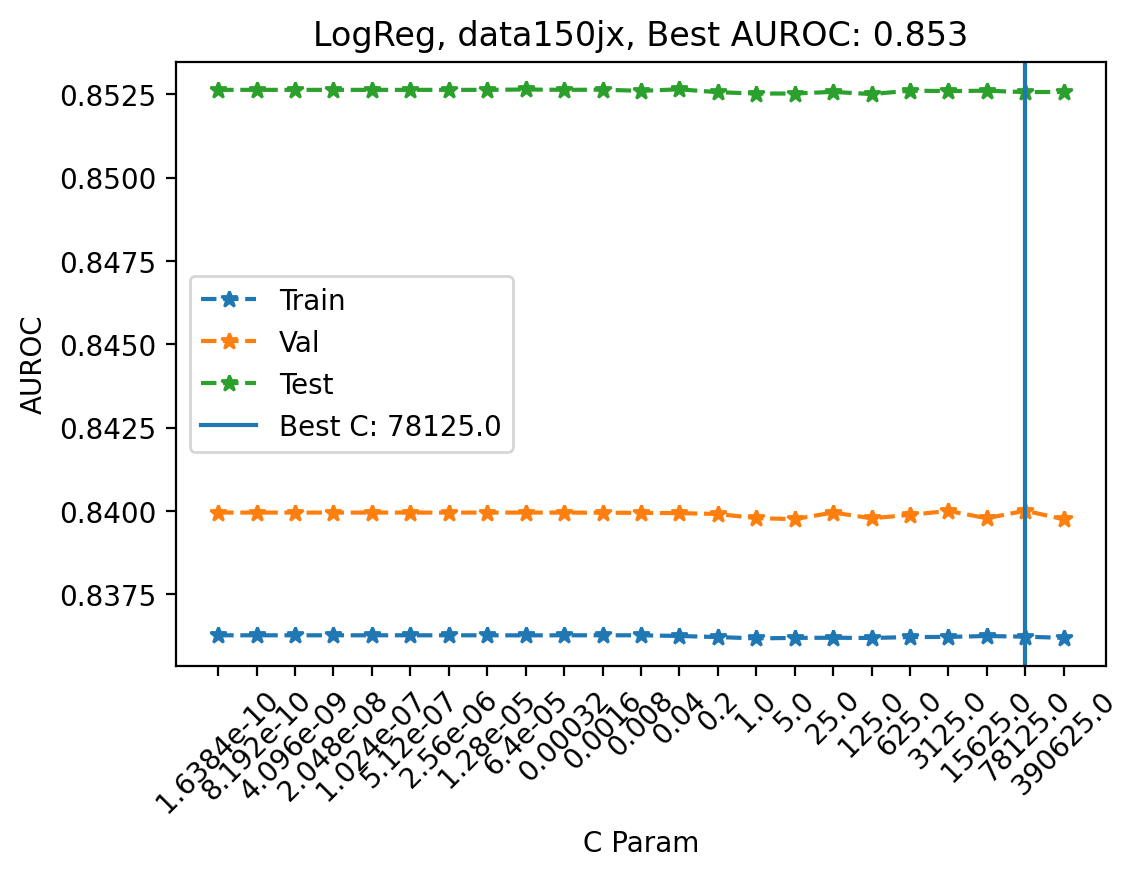

<Figure size 432x288 with 0 Axes>

In [10]:
# Settings
c_param = [5**(i) for i in np.arange(-14,9,dtype=float)]
dataname = gen_model_args['savepath'] # 'data150v3-1'
logreg_args = np.load(os.path.join(dataname,'args.npy'), allow_pickle=True).item()
logreg_args['d'] = 1
logreg_args['cp_type'] = 'avg_cp' # 'true_cp' # jx true_cp is the oracle, avg_cp is the non-oracle

# Import Data
X_logreg, y_logreg = load_data_logreg(logreg_args)

# HP Search: C param
results = np.empty((3,len(c_param)))
for cind, c in enumerate(c_param):
    clf=linear_model.LogisticRegression(penalty='l2',class_weight='balanced',C=c,solver='liblinear')
    clf.fit(X_logreg[0], y_logreg[0])
    idx=np.where(clf.classes_==1)[0]
    
    # Train/Val/Test
    for ind in range(3): 
        yhat = clf.predict_proba(X_logreg[ind])[:,idx]
        results[ind,cind] = roc_auc_score(y_logreg[ind], yhat.flatten())

# Best C Value by Val Perf
best_ind = np.argmax(results[1,:]) 
c = c_param[best_ind]
print('Best C: {}'.format(c))

# Train Best Model
clf=linear_model.LogisticRegression(penalty='l2',class_weight='balanced',C=c,solver='liblinear')
clf.fit(X_logreg[0], y_logreg[0])
idx=np.where(clf.classes_==1)[0]

# Emp Bootstrap of AUC
print('Best Test AUROC (val chosen): {:.3f}'.format(results[2,best_ind]))
yhat = clf.predict_proba(X_logreg[2])[:,idx]
sample_auroc = roc_auc_score(y_logreg[2], yhat.flatten())
print('Sanity Check of Above #: {:.3f}'.format(sample_auroc))
print('95% CI, emp b.s.: ',emp_bootstrap_auc(y_logreg[2], yhat, sample_auroc))

# Plot Train/Val/Loss over C values
fig, ax = plt.subplots(1,1, dpi=200)
for ind, datatype in [(0,'Train'),(1,'Val'),(2,'Test')]:
    plt.plot(np.arange(len(c_param)), results[ind,:], '*--', label=datatype)
plt.axvline(x=best_ind, label='Best C: '+str(c_param[best_ind]))
plt.legend()
plt.title('LogReg, '+logreg_args['savepath']+', Best AUROC: '+str(np.round(results[2,best_ind],decimals=3)))
plt.xlabel('C Param')
plt.xticks(np.arange(len(c_param)), c_param, rotation=45)
plt.ylabel('AUROC')
plt.show()
plt.clf()

### Learn GCN

In [11]:
gcn_args = {'output_size':2, 
            'batch_size':1, 
            'num_A':1,
            'l2':.001,
            'dropout':0.01, 
            'epochs': 160, 
            'budget': 24, # decrease to make it faster
            'save_epoch':1,
            'patience':5, 
            'savepath':'/data4/jeeheh/ShadowPeriod/Toy2', 
            'graph_split_func': graph_split,
            'cuda':0,
            'save_attn':False,
            'dataname': gen_model_args['savepath'], 
            'description':''}

gen_model_args = np.load(os.path.join(gcn_args['savepath'],gcn_args['dataname'],'args.npy'), allow_pickle=True).item()
for args in ['num_datasets_train', 'num_datasets_val', 'num_datasets_test', 'num_datasets']:
    gcn_args[args] = gen_model_args[args]
gcn_args['codename'] = return_file_name().split('/')[-1][:-3]
torch.cuda.set_device(gcn_args['cuda'])

In [12]:
# we may want to consider adding weight. 
gcn_args['weight'] = torch.FloatTensor([1,(1-gen_model_args['trainval_class_imb'])/gen_model_args['trainval_class_imb']]) #NEW
# gcn_args['weight'] = torch.FloatTensor([1,1])

In [13]:
data_bundle = data_bundler(gcn_args)

Orig GCN settings
gcn_args['HP'] = {'hidden_size':[100,200,400,800,1000], 'embedding_size':[100,200,400,800,1000]}
gcn_args['depth'] = 2

Orig GAT settings
gcn_args['HP'] = {'hidden_size':[50,100,200,400,800], 'embedding_size':[50,100,200,400,800], 'nheads':[1,3,5]}
gcn_args['depth'] = 2

In [14]:
from inprog166v22_jx import GCNa11

In [ ]:
gcn_args['GCN'] = GCNa11
name_list = []

# GAT
gcn_args['alpha'] = .2 #from GAT paper
gcn_args['HP'] = {'hidden_size':[50,100,200,400], 'embedding_size':[50,100,200,400], 'nheads':[1,3,5]}

gcn_args['attention'] = True
gcn_args['ego_v_nbr'] = False
gcn_args['kdeg_nbr'] = False
gcn_args['residual'] = False

for depth in [1,2,3,4,5]:
    gcn_args['depth']=depth
    gcn_args['name'] = "results/{}{}d={:.0f}{}_{}{}".format(
                        gcn_args['codename'],
                        'GAT' if gcn_args['attention'] else 'GCN',
                        depth,
                        'res'*gcn_args['residual']+'ego'*gcn_args['ego_v_nbr']+'kdeg'*gcn_args['kdeg_nbr'],\
                        gcn_args['dataname'],gcn_args['description'])
    print(gcn_args['name'],'---------------------------------')
    name_list.append(gcn_args['name'])
    train_models(gcn_args, data_bundle)

results/inprog166v22_jxGATd=1_data150jx ---------------------------------
-- Budget 0
-- -- Epoch 0: loss 0.693, 0.693
-- -- Epoch 1: loss 0.693, 0.693
-- -- Epoch 2: loss 0.693, 0.693
-- -- Epoch 3: loss 0.693, 0.693
-- -- Epoch 4: loss 0.693, 0.693
-- -- Epoch 5: loss 0.693, 0.693
-- -- Epoch 6: loss 0.693, 0.693
-- -- Epoch 7: loss 0.693, 0.693
-- -- Epoch 8: loss 0.693, 0.693
-- -- Epoch 9: loss 0.693, 0.693
-- -- Epoch 10: loss 0.693, 0.693
-- Budget 1
-- -- Epoch 0: loss 0.605, 0.578
-- -- Epoch 1: loss 0.565, 0.508
-- -- Epoch 2: loss 0.478, 0.458
-- -- Epoch 3: loss 0.442, 0.458
-- -- Epoch 4: loss 0.436, 0.444
-- -- Epoch 5: loss 0.436, 0.456
-- -- Epoch 6: loss 0.437, 0.454
-- -- Epoch 7: loss 0.437, 0.450
-- -- Epoch 8: loss 0.434, 0.447
-- -- Epoch 9: loss 0.436, 0.448
-- -- Epoch 10: loss 0.430, 0.442
-- -- Epoch 11: loss 0.431, 0.441
-- -- Epoch 12: loss 0.432, 0.452
-- -- Epoch 13: loss 0.434, 0.444
-- -- Epoch 14: loss 0.431, 0.443
-- -- Epoch 15: loss 0.431, 0.443
-- -

# Results

In [ ]:
#name_list = ['inprog150v3'+str(i)+'_' + gen_model_args['savepath'] +gcn_args['description']+'.npz' \
#             for i in ['a','a2','a11','i','i2','i11']]

name_list = ['inprog166v22_jxGATd=1res_data150jx.npz',
             'inprog166v22_jxGATd=2res_data150jx.npz',
             'inprog166v22_jxGATd=1_data150jx.npz',
             'inprog166v22_jxGCNd=1resegokdeg_data150jx.npz']

### Calculate AUC as we do for LogReg

In [ ]:
df = pd.DataFrame({})

for name in name_list:
    print(name)
    zdf = {}
    
    # Reload
    # results = np.load(os.path.join(gcn_args['savepath'],'',name),allow_pickle=True)
    results = np.load(os.path.join(gcn_args['savepath'],'results',name),allow_pickle=True)
    acc = results['acc'].item()
    trainval_loss = results['trainval_loss']
    model_args = np.load(os.path.join(gcn_args['savepath'],'results',name[:-4]+'args.npy'),allow_pickle=True).item()
    # model_args = np.load(os.path.join(gcn_args['savepath'],'',name[:-4]+'args.npy'),allow_pickle=True).item()
    best_budget = np.argmax(acc['val'])
        
    # Populate Dictionary
    zdf['l2'] = model_args['l2']
    zdf['auroc'] = acc['test'][best_budget]
    zdf['name'] = name[:-4]
    zdf['mean_val_auc'] = np.mean(acc['val'])
    zdf['mean_test_auc'] = np.mean(acc['test'])
    zdf['best_val_auc'] = np.amax(acc['val'])
    for key in model_args['HP']:
        zdf[key] = model_args[key]
    
    zdf = pd.DataFrame(zdf, index=[name_list.index(name)])
    df = df.append(zdf, sort=True)
    
    # TrainVal Loss Plot
    trainval_loss.shape # budget, epochs, (train vs val)
    fig, ax = plt.subplots(1,1,dpi=75)
    for budget in range(gcn_args['budget']):
        try:
            last_epoch = min(np.where(trainval_loss[budget,:,1]==0)[0])
        except:
            last_epoch = model_args['epochs']
        p = ax.plot(np.arange(last_epoch),trainval_loss[budget,:last_epoch,0],'--',
                    label=f'budget {budget} tr') 
        ax.plot(np.arange(last_epoch),trainval_loss[budget,:last_epoch,1],"-",
                markevery=100,color=p[-1].get_color(),alpha=.5, 
                label=f'budget {budget} val')
    plt.title('TrainVal Loss '+name)
    plt.xlabel('Epochs')
    plt.ylabel('Cross Entropy Loss')
    plt.legend()
    plt.show()
    plt.clf()

In [ ]:
df[['name', 'auroc', 'best_val_auc']] #, 'l2', 'embedding_size', 'nheads', 'mean_test_auc', 'mean_val_auc']]

In [ ]:
df

### Calculate Bootstrapped AUC for best model

In [ ]:
def bootstrap_auc_from_model(runpath):
    
    # Load args
    args = np.load(runpath+'args.npy',allow_pickle=True).item()
    
    # Load Model
    model = args['GCN'](args).cuda()
    model.load_state_dict(torch.load(runpath+'.pth.tar'))
    model.eval()

    # Load Test Data
    S, target, A, pop, gid = preload_data(args,np.arange(args['num_datasets']-args['num_datasets_test'], args['num_datasets']))  
    
    # For each network in Test
    yhat_y = {'yhat':[], 'y':[]}
    for S_, target_, A_, pop_, gid_ in zip(S, target, A, pop, gid):

        # -- Save yhat & y
        yhat_, y_= auroc(args, model, S_, target_, A_, pop_, gid_)
        yhat_y['y'].append(y_)
        yhat_y['yhat'].append(yhat_)

    # Calculate AUROC to match LogReg's Calculation (Over all datasets)
    yhat_y['yhat'] = np.concatenate(yhat_y['yhat'], axis=0)
    yhat_y['y'] = np.concatenate(yhat_y['y'], axis=0)
    yhat_y['auroc'] = roc_auc_score(yhat_y['y'], yhat_y['yhat'])

    # Calculate empirical bootstrap of the auc
    return yhat_y['auroc'], emp_bootstrap_auc(yhat_y['y'], yhat_y['yhat'], yhat_y['auroc'])


# runpath = '/data4/jeeheh/ShadowPeriod/Toy2/results/' + 'inprog166v22_jxGATd=1res_' + gen_model_args['savepath']
runpath = '/data4/jeeheh/ShadowPeriod/Toy2/results/' + 'inprog166v22_jxGCNd=1resegokdeg_' + gen_model_args['savepath']
a, (b,c) = bootstrap_auc_from_model(runpath)
print('{:.3f} ({:.3f},{:.3f})'.format(a,b,c))

In [ ]:
runpath = '/data4/jeeheh/ShadowPeriod/Toy2/results/' + 'inprog166v22_jxGATd=1res_' + gen_model_args['savepath']
a, (b,c) = bootstrap_auc_from_model(runpath)
print('{:.3f} ({:.3f},{:.3f})'.format(a,b,c))